In [9]:
!pip install wfdb

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour charger les données et les annotations
def load_patient_data(patient_id):
    # Charger le signal ECG
    record = wfdb.rdrecord(f'/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0-20250509T221630Z-001/mit-bih-arrhythmia-database-1.0.0/{patient_id}', channels=[0])
    signal = record.p_signal.flatten()

    # Charger les annotations
    annotation = wfdb.rdann(f'//content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0-20250509T221630Z-001/mit-bih-arrhythmia-database-1.0.0/{patient_id}', 'atr')

    return signal, annotation.sample, annotation.symbol

# Exemple : Charger les données du patient 101
signal, annotation_samples, annotation_symbols = load_patient_data('101')

In [12]:
def create_labeled_dataset(patient_ids, segment_length=1800):
    X, y = [], []
    for pid in patient_ids:
        signal, annotation_samples, annotation_symbols = load_patient_data(pid)
        num_segments = len(signal) // segment_length
        labels = np.zeros(num_segments)  # 0 = Normal, 1 = Anomalie

        # Parcourir les annotations pour étiqueter les segments
        for sample, symbol in zip(annotation_samples, annotation_symbols):
            if symbol != 'N':  # 'N' = Normal, les autres symboles = Anomalies
                segment_idx = sample // segment_length
                if segment_idx < num_segments:
                    labels[segment_idx] = 1  # Marquer comme anormal

        # Découper le signal en segments
        segments = [signal[i:i+segment_length] for i in range(0, len(signal), segment_length)[:num_segments]]
        X.extend(segments)
        y.extend(labels)

    return np.array(X), np.array(y)

# Liste de tous les patients disponibles dans MIT-BIH
patient_ids = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
    '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

# Créer le dataset avec tous les patients
X, y = create_labeled_dataset(patient_ids)

# Vérifier la répartition des classes
print("Répartition des classes :", np.unique(y, return_counts=True))

Répartition des classes : (array([0., 1.]), array([8377, 8951]))


In [13]:
from sklearn.model_selection import train_test_split

# Normalisation des données
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Redimensionner pour le modèle
X_train = X_train.reshape(-1, 1800, 1)
X_test = X_test.reshape(-1, 1800, 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout

model = Sequential([
    # Couches CNN pour extraire les features locales
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(1800, 1)),
    MaxPooling1D(2),
    Dropout(0.5),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.5),

    # Couche LSTM pour capturer les dépendances temporelles
    LSTM(64, return_sequences=False),
    Dropout(0.5),

    # Couches fully connected
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Classification binaire
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1798, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 899, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 899, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 897, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 448, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 448, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,593 (307.00 KB)

 Trainable params: 78,593 (307.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Calculer les poids des classes
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}

# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights
)

Epoch 1/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5213 - loss: 0.6915 - val_accuracy: 0.5915 - val_loss: 0.6460
Epoch 2/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.5539 - loss: 0.6765 - val_accuracy: 0.5678 - val_loss: 0.6798
Epoch 3/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5635 - loss: 0.6783 - val_accuracy: 0.7063 - val_loss: 0.6228
Epoch 4/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6634 - loss: 0.6263 - val_accuracy: 0.6143 - val_loss: 0.6495
Epoch 5/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6369 - loss: 0.6447 - val_accuracy: 0.7773 - val_loss: 0.4973
Epoch 6/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7362 - loss: 0.5289 - val_accuracy: 0.7807 - val_loss: 0.5002
Epoch 7/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.7426 - loss: 0.5354 - val_accuracy: 0.8312 - val_loss: 0.4136
Epoch 8/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8034 - loss: 0.4587 - 

In [16]:
from tensorflow.keras.models import load_model

# Sauvegarder le modèle
model.save('model_ecg.h5')

# Charger le modèle
model_ecg = load_model('model_ecg.h5')
model_ecg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1798, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 899, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 899, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 897, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 448, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 448, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,595 (307.02 KB)

 Trainable params: 78,593 (307.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
              precision    recall  f1-score   support

         0.0       0.51      0.76      0.61      1695
         1.0       0.56      0.29      0.38      1771

    accuracy                           0.52      3466
   macro avg       0.53      0.53      0.50      3466
weighted avg       0.53      0.52      0.49      3466



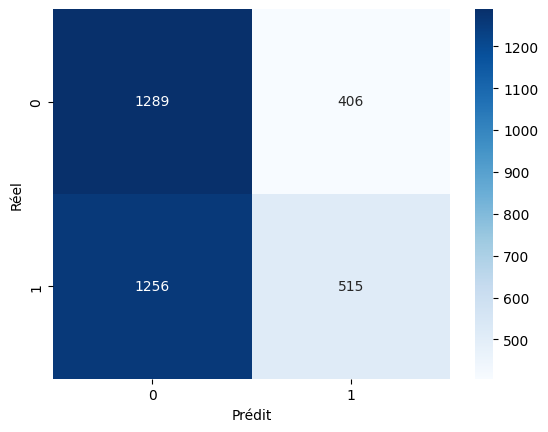

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Rapport de classification
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

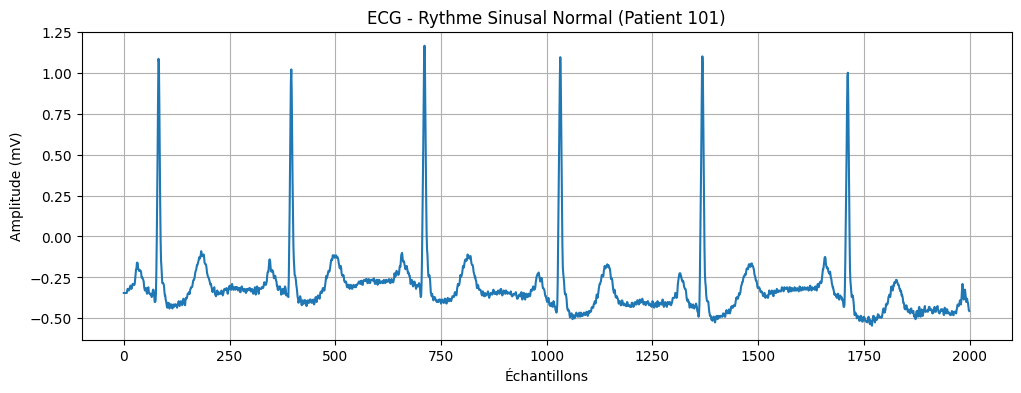

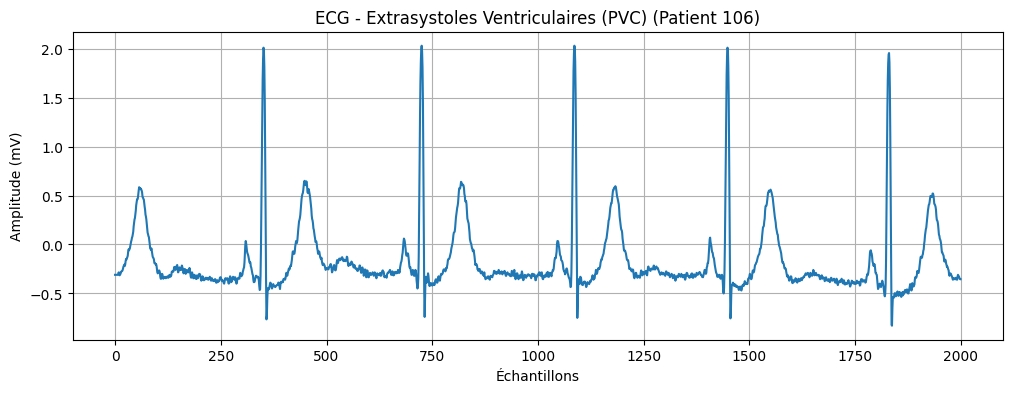

In [19]:
import wfdb
import matplotlib.pyplot as plt

# Fonction pour charger et visualiser un ECG
def plot_ecg(patient_id, title):
    # Charger le signal ECG
    record = wfdb.rdrecord(f'//content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0-20250509T221630Z-001/mit-bih-arrhythmia-database-1.0.0/{patient_id}', channels=[0])
    signal = record.p_signal.flatten()

    # Charger les annotations
    annotation = wfdb.rdann(f'//content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0-20250509T221630Z-001/mit-bih-arrhythmia-database-1.0.0/{patient_id}', 'atr')

    # Visualiser le signal
    plt.figure(figsize=(12, 4))
    plt.plot(signal[:2000])  # Afficher les 2000 premiers échantillons (~5.5 secondes)
    plt.title(f"ECG - {title} (Patient {patient_id})")
    plt.xlabel("Échantillons")
    plt.ylabel("Amplitude (mV)")
    plt.grid()
    plt.show()

# Visualiser un ECG normal (Patient 101)
plot_ecg('101', 'Rythme Sinusal Normal')

# Visualiser un ECG anormal (Patient 106)
plot_ecg('106', 'Extrasystoles Ventriculaires (PVC)')

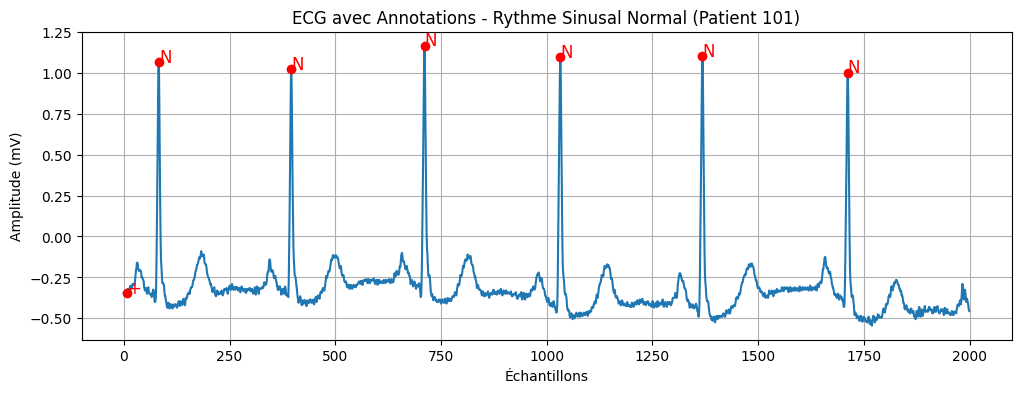

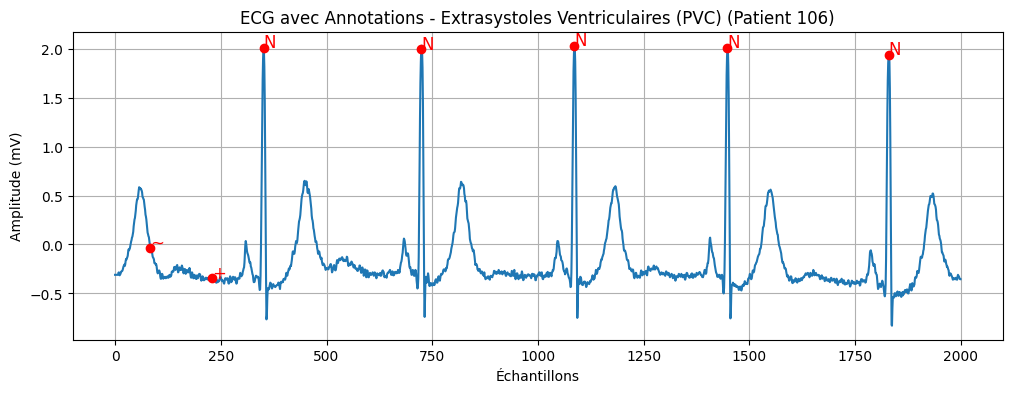

In [20]:
def plot_ecg_with_annotations(patient_id, title):
    # Charger le signal ECG
    record = wfdb.rdrecord(f'//content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0-20250509T221630Z-001/mit-bih-arrhythmia-database-1.0.0/{patient_id}', channels=[0])
    signal = record.p_signal.flatten()

    # Charger les annotations
    annotation = wfdb.rdann(f'//content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0-20250509T221630Z-001/mit-bih-arrhythmia-database-1.0.0/{patient_id}', 'atr')

    # Visualiser le signal avec les annotations
    plt.figure(figsize=(12, 4))
    plt.plot(signal[:2000])  # Afficher les 2000 premiers échantillons
    plt.title(f"ECG avec Annotations - {title} (Patient {patient_id})")
    plt.xlabel("Échantillons")
    plt.ylabel("Amplitude (mV)")

    # Afficher les annotations
    for sample, symbol in zip(annotation.sample, annotation.symbol):
        if sample < 2000:  # Se limiter aux 2000 premiers échantillons
            plt.plot(sample, signal[sample], 'ro')  # Marquer les annotations en rouge
            plt.text(sample, signal[sample], symbol, fontsize=12, color='red')

    plt.grid()
    plt.show()

# Visualiser un ECG normal avec annotations (Patient 101)
plot_ecg_with_annotations('101', 'Rythme Sinusal Normal')

# Visualiser un ECG anormal avec annotations (Patient 106)
plot_ecg_with_annotations('106', 'Extrasystoles Ventriculaires (PVC)')

In [21]:
def inspect_patient(patient_id):
    signal, ann_samples, ann_symbols = load_patient_data(patient_id)
    segments = [signal[i:i+1800] for i in range(0, len(signal), 1800)]
    labels = np.zeros(len(segments))  # 0 = Normal, 1 = Anomalie

    for sample, symbol in zip(ann_samples, ann_symbols):
        segment_idx = sample // 1800
        if segment_idx < len(segments):
            if symbol != 'N':  # Si une seule annotation est non-'N', le segment est anormal
                labels[segment_idx] = 1

    # Afficher les résultats
    print(f"Patient {patient_id} - Segments normaux: {np.sum(labels == 0)}, Segments anormaux: {np.sum(labels == 1)}")

Text(value='101', description='Patient ID:', placeholder='Entrez un ID de patient (ex: 101)')

Button(description='Tester le signal', style=ButtonStyle())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


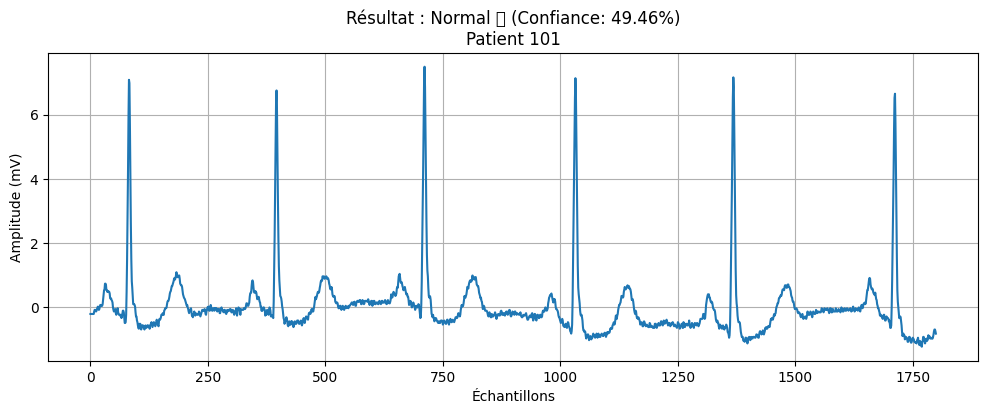

In [26]:
# Installer ipywidgets si ce n'est pas déjà fait
# !pip install ipywidgets

# Importer les bibliothèques nécessaires
import ipywidgets as widgets
from IPython.display import display
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Charger le modèle (assure-toi qu'il est déjà entraîné)
model = load_model('/content/model_ecg.h5')  # Décommente si tu as un modèle sauvegardé

# Fonction pour tester un signal ECG
def test_ecg_signal(patient_id):
    try:
        # Charger le signal ECG
        record = wfdb.rdrecord(f'//content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0-20250509T221630Z-001/mit-bih-arrhythmia-database-1.0.0/{patient_id}', channels=[0])
        signal = record.p_signal.flatten()[:1800]  # Prendre les 1800 premiers échantillons

        # Prétraiter le signal
        signal = (signal - np.mean(signal)) / np.std(signal)
        signal = signal.reshape(1, 1800, 1)

        # Faire la prédiction
        prediction = model.predict(signal)[0][0]
        result = "Anomalie ⚠️" if prediction > 0.5 else "Normal ✅"

        # Afficher le résultat
        plt.figure(figsize=(12, 4))
        plt.plot(signal[0, :, 0])
        plt.title(f"Résultat : {result} (Confiance: {prediction:.2%})\nPatient {patient_id}")
        plt.xlabel("Échantillons")
        plt.ylabel("Amplitude (mV)")
        plt.grid()
        plt.show()
    except:
        print(f"Erreur : Patient {patient_id} non trouvé ou problème de chargement.")

# Créer le formulaire interactif
patient_id_input = widgets.Text(
    value='101',
    placeholder='Entrez un ID de patient (ex: 101)',
    description='Patient ID:',
    disabled=False
)

test_button = widgets.Button(description="Tester le signal")

def on_button_click(b):
    test_ecg_signal(patient_id_input.value)

test_button.on_click(on_button_click)

# Afficher le formulaire
display(patient_id_input, test_button)

In [27]:
import numpy as np

# Générer un signal ECG normal
normal_signal = np.random.normal(loc=0, scale=0.1, size=1800)
np.savetxt("exemple_normal.txt", normal_signal, fmt="%.6f")

# Générer un signal ECG avec anomalie
anomaly_signal = np.random.normal(loc=0, scale=0.1, size=1800)
anomaly_signal[500:510] += 0.2  # Ajouter une anomalie
np.savetxt("exemple_anomalie.txt", anomaly_signal, fmt="%.6f")